In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
#!cp "/content/drive/My Drive/Colab Notebooks/attention_keras/src/layers/attention.py" .

In [4]:
import attention

AttentionLayer was taken from here https://github.com/thushv89/attention_keras

In [5]:
from attention import AttentionLayer

In [6]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from os import listdir

In [7]:
import tensorflow as tf
tf.__version__

'2.3.0'

#Read the dataset

CNN daily mail dataset consists of long news articles(an average of ~800 words). It consists of both articles and summaries of those articles.

In [8]:
import zipfile
import os

In [9]:
zpfile = '/content/drive/My Drive/Colab Notebooks/cnn_stories.zip'
z = zipfile.ZipFile(zpfile, 'r')
z.extractall()

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only

	file = open(filename, encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights
 
# load all stories in a directory
def load_stories(directory):
	stories = list()
	for name in listdir(directory):
		filename = directory + '/' + name
		# load document
		doc = load_doc(filename)
		# split into story and highlights
		story, highlights = split_story(doc)
		# store
		stories.append({'story':story, 'highlights':highlights})
	return stories
 
# load stories
directory = 'cnn_stories/cnn/stories/'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

Loaded Stories 92579


In [ ]:
zpfile_1 = '/content/drive/My Drive/Colab Notebooks/dailymail_stories.zip'
z = zipfile.ZipFile(zpfile_1, 'r')
z.extractall()

In [ ]:
directory = 'dailymail_stories/dailymail/stories/'
stories_dailymail = load_stories(directory)
print('Loaded Stories %d' % len(stories_dailymail))

Loaded Stories 219506


In [ ]:
import string


# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	# prepare a translation table to remove punctuation
	table = str.maketrans('', '', string.punctuation)
	for line in lines:
		# strip source cnn office if it exists
		index = line.find('(CNN) -- ')
		if index > -1:
			line = line[index+len('(CNN)'):]
		# tokenize on white space
		line = line.split()
		# convert to lower case
		line = [word.lower() for word in line]
		# remove punctuation from each token
		line = [w.translate(table) for w in line]
		# remove tokens with numbers in them
		line = [word for word in line if word.isalpha()]
		# store as string
		cleaned.append(' '.join(line))
	# remove empty strings
	cleaned = [c for c in cleaned if len(c) > 0]
	return cleaned

# clean stories
for example in stories:
	example['story'] = clean_lines(example['story'].split('\n'))
	example['highlights'] = clean_lines(example['highlights'])

In [ ]:
data_cnn= pd.DataFrame(stories)

In [ ]:
# clean stories
for example in stories_dailymail:
	example['story'] = clean_lines(example['story'].split('\n'))
	example['highlights'] = clean_lines(example['highlights'])

In [ ]:
data_dailymail= pd.DataFrame(stories_dailymail)

In [ ]:
data_dailymail.head()

,story,highlights
0,"[a former gymnast who represented her country numerous times and won medals for her skills has now been exposed as a highclass prostitute who earns a night, florica leonida from the romanian capit...","[florica leonida from bucharest is a former silver world medallist, but she said becoming a prostitute was the only way to make ends meet, she works under a different name currently residing in a ..."
1,"[by, daily mail reporter, published, est april, updated, est september, a champion swimmer spied on a woman using a pair of mirrored goggles to peek under a changing room cubicle a court heard fre...","[married james mackay used goggles to watch same woman in cubicle three times, he set the british freestyle record in, update since publication of this article mr mackay successfully appealed agai..."
2,"[liverpool cruised to a win over swansea to ease the pressure on brendan rodgers at anfield, alberto moreno fired the hosts ahead before a brace from adam lallana either side of gylfi sigurdssons ...","[former southampton midfielder adam lallana scored a brace in win, jonjo shelvey who used to play for liverpool endured a miserable game, the win pushes liverpool level on points but above swansea..."
3,"[by, daily mail reporter, published, est december, updated, est december, anderson cooper shocked viewers on thursday night by discussing his mother and oral sex in one outrageous anecdote, the cn...",[the cnn anchor was hosting his review of the year show when he made the shocking remark]
4,"[wasps fans have been told to accept the reality of professional sport following the watershed purchase of ricoh arena in a move which paves the way for nflstyle franchises in rugby union, the two...","[wasps came close to going bankrupt two years ago and confirmed on wednesday that they have agreed a deal to move to the ricoh arena, coventry city council have sold the club a per cent share in t..."


In [ ]:
data = data_cnn.append(data_dailymail, ignore_index=True)

In [ ]:
data.tail()

,story,highlights
312080,"[by, louise eccles and becky barrow, last updated at am on january, hundreds of railway staff will be paid simply for agreeing to work without disruption during the olympics, it also emerged yeste...","[workers on driverless dlr network offered per cent overtime increase during the games, union describes pay deal as truly groundbreaking, critics accuse rail bosses of bribing staff not to strike]"
312081,"[by, ellie zolfagharifard, published, est october, updated, est october, a powerful solar flare directed at earth has put on majestic display of the northern lights across parts of canada the us a...","[a solar explosion crashed into earths magnetic field on tuesday allowing photographers to capture these images, solar flares create auroras when radiation from the sun reaches earth and mixes wit..."
312082,"[by, louise saunders, published, est august, updated, est august, when the only way is essexs tom kilbey started dating lydia bright it was clear he was never going to be best pals with her exboyf...","[lucy mecklenburgh vs sam faiers, gemma collins vs charlie king and bobby cole norris, joey essex vs jamie reed]"
312083,"[by, steve doughty social affairs correspondent, fortnightly rubbish collections are a threat to public health government guidance warned yesterday, it said that no longer picking up bins from hom...","[guidance was issued yesterday by department led by eric pickles, he has pushed councils to make weekly bin collections with grant, surprise announcement puts mr pickles on collision course with d..."
312084,"[the remains of two dinosaurs that were perfectly preserved in a bitter fight to the death are to be sold for a record million, the fossil of the tyrannosaurus and a triceratops locked in mortal c...","[tyrannosaurus and triceretops were found in, perfectly preserved fossils show them embraced in a fight to the death, chance discovery is thought to be among the most important of all time, expert..."


In [ ]:
data.rename(columns={"highlights": "Summary", "story": "Text"}, inplace=True)

In [ ]:
data['Text'] = data['Text'].apply(lambda x: ' '.join(x) )

In [ ]:
for i in range(len(data['Summary'])):
  data['Summary'][i]=data['Summary'][i][0]

### Drop Duplicates and NA values

In [11]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

### Information about dataset


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308827 entries, 0 to 312084
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     308827 non-null  object
 1   Summary  308827 non-null  object
dtypes: object(2)
memory usage: 7.1+ MB


In [ ]:
data.to_csv("cnn_dailymail_before_processing_2510.csv")

In [10]:
data = pd.read_csv("cnn_dailymail_before_processing_2510.csv")

In [12]:
data.head()

,Unnamed: 0,Text,Summary
0,0,for architects perfection is necessary said japanese architect kengo kuma it is my mission to use the kindness and delicateness that old architecture had i believe that this mission is not easy to...,japanese architect has popularized sensitive japanese traditions in buildings
1,1,the trial of former egyptian president mohamed morsy on charges of inciting the murders of at least three protesters in has been postponed until february because he did not appear in court wednesd...,the second session in the trial of mohamed morsy is postponed until february
2,2,cnn toyota motor corp has recently been in the hot seat after issuing massive recalls because of problems related to the accelerator pedal in several of its auto models to date million vehicles wo...,million vehicles worldwide have been recalled by toyota
3,3,mexicos international image may be taking hits because of the violence produced by drug cartels but it hasnt hurt its tourism industry officials say international tourism to mexico has increased i...,mexico remains the no destination for americans traveling abroad
4,4,thai scrapyard workers accidentally detonated a suspected world war iiera bomb wednesday killing seven and injuring after attempting to cut into it with a blowtorch the device was discovered at a ...,suspected wwiiera aerial bomb explodes in bangkok neighborhood killing seven


In [ ]:
from google.colab import files
files.download("cnn_dailymail_before_processing_2510.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Preprocessing

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Eliminate punctuations and special characters


Let’s define the function:

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import string

In [15]:
stop_words = set(stopwords.words('english')) 

In [16]:
def text_cleaner(text,num):
    
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    for c in string.punctuation:
      newString = newString.replace(c,"")
       
    newString = re.sub(r"'s\b","",newString)
    
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>0:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [17]:
cleaned_text = []
k=0
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,1)) 

Let us look at the first five preprocessed reviews

In [18]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [19]:
cleaned_summary[:5]

['japanese architect has popularized sensitive japanese traditions in buildings',
 'the second session in the trial of mohamed morsy is postponed until february',
 'million vehicles worldwide have been recalled by toyota',
 'mexico remains the no destination for americans traveling abroad',
 'suspected wwiiera aerial bomb explodes in bangkok neighborhood killing seven']

In [20]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [21]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### Understanding the distribution of the sequences

Here is an analysis of the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help to fix the maximum length of the sequence:

In [22]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

In [23]:
length_df.head()

,text,summary
0,689,9
1,553,13
2,440,8
3,893,9
4,252,10


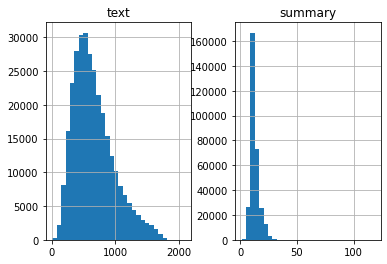

In [24]:
length_df.hist(bins = 30)
plt.show()

We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [25]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=17):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.8897923102329467


In [26]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=150):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.009066594133913594


Let us fix the maximum length of review to 120 and length of summary to 17.


In [27]:
max_text_len=120
max_summary_len=17

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [28]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])


In [29]:
len(cleaned_text)

308826

In [30]:
max_text_len

120

In [31]:
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if (len(cleaned_summary[i].split())>max_summary_len):
        short_summary.append(" ".join(cleaned_summary[i].split()[:17]))
    else:
        short_summary.append(cleaned_summary[i])
    
    if(len(cleaned_text[i].split())>max_text_len):
        short_text.append(" ".join(cleaned_text[i].split()[:120]))
    else:
        short_text.append(cleaned_text[i])
       
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

adding the **START** and **END** special tokens at the beginning and end of the summary.

In [32]:
df['summary'] = df['summary'].apply(lambda x : 'xl '+ x + ' xy')

In [33]:
df.shape

(308826, 2)

In [34]:
df.head()

,text,summary
0,for architects perfection is necessary said japanese architect kengo kuma it is my mission to use the kindness and delicateness that old architecture had i believe that this mission is not easy to...,xl japanese architect has popularized sensitive japanese traditions in buildings xy
1,the trial of former egyptian president mohamed morsy on charges of inciting the murders of at least three protesters in has been postponed until february because he did not appear in court wednesd...,xl the second session in the trial of mohamed morsy is postponed until february xy
2,cnn toyota motor corp has recently been in the hot seat after issuing massive recalls because of problems related to the accelerator pedal in several of its auto models to date million vehicles wo...,xl million vehicles worldwide have been recalled by toyota xy
3,mexicos international image may be taking hits because of the violence produced by drug cartels but it hasnt hurt its tourism industry officials say international tourism to mexico has increased i...,xl mexico remains the no destination for americans traveling abroad xy
4,thai scrapyard workers accidentally detonated a suspected world war iiera bomb wednesday killing seven and injuring after attempting to cut into it with a blowtorch the device was discovered at a ...,xl suspected wwiiera aerial bomb explodes in bangkok neighborhood killing seven xy


In [35]:
# df.to_csv("cnn_dailymail_after_processing_long.csv")

In [36]:
#files.download("cnn_dailymail_after_processing_long.csv")

We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [37]:
from sklearn.model_selection import train_test_split
x_tr1,x_val1,y_tr1,y_val1=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=False) 

### Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

### Text Tokenizer

In [38]:
!pip install youtokentome 

     |████████████████████████████████| 1.7MB 8.5MB/s 


In [39]:
import youtokentome as yttm

In [40]:
x_tokenizer = yttm.BPE(model='bpe.model')

In [42]:
print(x_tokenizer.encode([x_tr1[0]], output_type=yttm.OutputType.SUBWORD, dropout_prob=0.1))     

[['▁for', '▁ar', 'ch', 'it', 'ect', 's', '▁perfection', '▁is', '▁necessary', '▁said', '▁japanese', '▁ar', 'ch', 'it', 'ect', '▁k', 'en', 'go', '▁k', 'uma', '▁it', '▁is', '▁my', '▁mission', '▁to', '▁use', '▁the', '▁kind', 'ness', '▁and', '▁delic', 'at', 'eness', '▁that', '▁old', '▁ar', 'ch', 'it', 'ect', 'ure', '▁had', '▁i', '▁believe', '▁that', '▁this', '▁mission', '▁is', '▁not', '▁easy', '▁to', '▁complete', '▁so', '▁i', '▁am', '▁planning', '▁to', '▁work', '▁until', '▁i', '▁fall', '▁down', '▁with', '▁nearly', '▁projects', '▁on', '▁the', '▁go', '▁across', '▁the', '▁world', '▁k', 'um', 'as', '▁search', '▁for', '▁perfection', '▁is', '▁all', '▁consuming', '▁he', '▁rarely', '▁takes', '▁a', '▁day', '▁off', '▁from', '▁work', '▁and', '▁sometimes', '▁even', '▁finished', '▁projects', '▁are', '▁analy', 'zed', '▁and', '▁amend', 'ed', '▁the', '▁from', '▁to', 'ky', 'o', '▁has', '▁become', '▁syn', 'onymous', '▁with', '▁delicate', '▁simplicity', '▁and', '▁sensitivity', '▁to', '▁a', '▁build', 'ings', '

In [44]:
x_tr_seq    =   x_tokenizer.encode(list(x_tr1), output_type=yttm.OutputType.ID)
x_val_seq   =   x_tokenizer.encode(list(x_val1), output_type=yttm.OutputType.ID)

In [47]:
max=0
for x in x_val_seq:
    if len(x)>max:
        max=len(x)
      
print(max) 
max_text_len=max

240


In [48]:
max=0
for x in x_tr_seq:
    if len(x)>max:
        max=len(x)
      
print(max) 
max_text_len=max

384


In [49]:
x_tr    =   pad_sequences([x for x in x_tr_seq],  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences([x for x in x_val_seq], maxlen=max_text_len, padding='post')

In [50]:
dic={}
for x in x_tr:
    
    for word in x:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1
            
for x in x_val:
    
    for word in x:
        if word in dic:
            dic[word]+=1
        else:
            dic[word]=1           

In [51]:
len(dic)

18083

define max integer representation of tokens

In [52]:
max=0
for x in x_tr:
    
    for word in x:
        
        if (word > max):
            max = word
for x in x_val:
    
    for word in x:
        
        if (word > max):
            max = word            
print(max)        

51999


In [53]:
#size of vocabulary ( +1 for padding token)
x_voc   =  max + 1

### Summary Tokenizer

Let us define the tokenizer with top most common words for summary.

In [54]:
#prepare a tokenizer for reviews on training data
y_tokenizer = yttm.BPE(model='bpe.model')

In [56]:
y_tr_seq    =   y_tokenizer.encode(list(y_tr1), output_type=yttm.OutputType.ID, dropout_prob=0.1)
y_val_seq   =   y_tokenizer.encode(list(y_val1), output_type=yttm.OutputType.ID, dropout_prob=0.1)

In [57]:
max=0
for x in y_val_seq:
    if len(x)>max:
        max=len(x)
print(max) 
max_summary_len=max

47


In [58]:
max=0
for x in y_tr_seq:
    if len(x)>max:
        max=len(x)
print(max) 
max_summary_len=max

53


In [59]:
#padding zero upto maximum length
y_tr    =   pad_sequences([y for y in y_tr_seq],  maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences([y for y in y_val_seq], maxlen=max_summary_len, padding='post')

In [60]:
max=0
for x in y_tr:
    
    for word in x:
        
        if (word > max):
            max = word
for x in y_val:
    
    for word in x:
        
        if (word > max):
            max = word            
print(max)       

51999


In [61]:
#size of vocabulary
y_voc  =   max +1

In [62]:
y_voc

52000

Here, I am deleting the rows that contain only **START** and **END** tokens

In [63]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [64]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. 

Here, we are building a 3 stacked Bi-LSTM for the encoder:

In [65]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm3(encoder_output2)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_text_len,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
# decoder   
decoder_lstm = LSTM(600, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_h, decoder_c = decoder_lstm(dec_emb,initial_state=encoder_states)

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 384, 100)     5200000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 384, 600), ( 962400      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 384, 600), ( 2162400     bidirectional[0][0]              
_______________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [66]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

The concept of early stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [68]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [69]:
# Создаем коллбек сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [70]:
#history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=35,callbacks=[cp_callback],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [71]:
#model.save_weights("bpe_model_35.h5")

In [72]:
# from google.colab import files
# files.download( "/content/bpe_model_35.h5" )

Load weights of already trained model

In [73]:
#model.load_weights("bpe_model_35.h5")

#Diagnostic plot


In [74]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

# Inference

Set up the inference for the encoder and decoder:

In [75]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, encoder_states])
#encoder_model = Model(inputs=encoder_inputs,outputs= encoder_states )

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2  = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_states_inputs],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process:

In [76]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    test=[]

    stop_condition = False
    decoded_sentence = ''
    decoded_sentence_test = ''
    k=0  
     
    while k<max_summary_len:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        test.append(sampled_token_index)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        k+=1
        # Update internal states
        e_h, e_c = h, c
     
    new_output=[]
    for i in test:
         if (i!=0 ):
           new_output.append(i)
    
    output = y_tokenizer.decode([new_output])
    
    
    newString=''
    for i in output[0].split(' '):
         
         if (i!='xl' and i!='xy' ):
             newString=newString+i+' '
    
    return newString

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [78]:
def seq2summary(input_seq):
    
     new_input=[]
     for i in range(len(input_seq)):
         if (input_seq[i]!=0 ):
           new_input.append(input_seq[i])
     
     output = y_tokenizer.decode([new_input]) 
     
     newString=''
     for i in output[0].split(' '):
         
         if (i!='xl' and i!='xy' ):
             newString=newString+i+' '
    
     return newString

def seq2text(input_seq):
     new_input=[]
     for i in input_seq:
         
         if (i!=0 ):
           new_input.append(i)
     return x_tokenizer.decode([new_input])

Here are a few summaries generated by the model:

In [103]:
for i in range(0,10):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: ['so far victims have come forward to describe the abuse they suffered at jimmy hands while in the care of the national health service below are the stories of just four of the vulnerable people he targeted one victim said nurses laughed when she told them she had been sexually assaulted by savile in a hospital basement so far victims have come forward to describe the abuse they suffered at jimmy hands while in the care of the national health service the woman who was then a patient at leeds general infirmary said savile made her feel like the taking her to the local shop and buying her sweets and magazines but she claimed that later a hospital porter led']
Original summary: so far victims have come forward to describe the abuse they suffered 
Predicted summary: victims abused by jimmy


Review: ['laurent koscielny is arsene wengers latest injury concern after he was released by france to return to arsenal for treatment on an achilles problem the knock is only regarded as minor

### Preparation for using metric Rouge

Make the dataframe with original and predicted summaries

In [104]:
original_summary = []
predicted_summary = []

In [106]:
for i in range(len(y_val)):
    original_summary.append(seq2summary(y_val[i]))

In [107]:
for i in range(len(original_summary)):
    original_summary[i] = re.sub('<s>','', original_summary[i])
    original_summary[i] = re.sub('<s','', original_summary[i])
    original_summary[i] = re.sub('xy','', original_summary[i])
    original_summary[i] = re.sub('<','', original_summary[i])
    original_summary[i] = original_summary[i].strip()

In [108]:
original_summary[:5]

['so far victims have come forward to describe the abuse they suffered',
 'laurent koscielny released by france to return to arsenal for treatment',
 'the princess royal chatted to team members before kickoff',
 'judy murray in talks to appear in the next series of strictly come dancing',
 'the floating hotel concept has been developed by a finnish architects firm']

In [110]:
for i in range(len(y_val)):
     predicted_summary.append(decode_sequence(x_val[i].reshape(1,max_text_len)))

In [111]:
for i in range(len(predicted_summary)):
    predicted_summary[i] = re.sub('<s>','', predicted_summary[i])
    predicted_summary[i] = re.sub('<s','', predicted_summary[i])
    predicted_summary[i] = re.sub('xy','', predicted_summary[i])
    predicted_summary[i] = re.sub('<','', predicted_summary[i])
    predicted_summary[i] = predicted_summary[i].strip()

In [112]:
dataframe = pd.DataFrame({'original_summary': original_summary, 'predicted_summary':predicted_summary})

Delete empty predictions

In [ ]:
np.where(dataframe['predicted_summary']=='')

(array([], dtype=int64),)

In [ ]:
np.where(dataframe['original_summary']=='')

(array([], dtype=int64),)

In [ ]:
dataframe = dataframe.drop(np.where(dataframe['predicted_summary']=='')[0])

In [ ]:
dataframe = dataframe.reset_index(drop=True)

In [113]:
dataframe.shape

(30883, 2)

In [ ]:
dataframe.to_csv('predictions_cnn_without_empty.csv')

Create two folders with txt original and predicted summaries

In [ ]:
for i in range(len(dataframe)):
    
    f = open('original_cnn/original_summary' + str(i) + '.txt', 'w', encoding="utf-8")
    f.write(dataframe['original_summary'][i])

In [ ]:
for i in range(len(dataframe)):
    
    f = open('predicted_cnn/predicted_summary' + str(i) + '.txt', 'w', encoding="utf-8")
    f.write(dataframe['predicted_summary'][i])

Import pyrouge

In [9]:
from pyrouge import Rouge155

In [10]:
r = Rouge155('C:/Users/Margarita/pyrouge/rouge/tools/ROUGE-1.5.5')

2020-11-01 13:05:31,055 [MainThread  ] [INFO ]  Set ROUGE home directory to C:/Users/Margarita/pyrouge/rouge/tools/ROUGE-1.5.5.


In [11]:
r.system_dir = 'C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/original_bilstm_lstm_secretiki' # Summaries to score against.
r.model_dir = 'C:/Users/Margarita/Documents/bpe_dropout/How-to-build-own-text-summarizer-using-deep-learning-master/predicted_bilstm_lstm_secretiki'  # Summaries generated by the model

In [12]:
r.system_filename_pattern = 'original_summary(\d+).txt'
r.model_filename_pattern = 'predicted_summary#ID#.txt'

In [1]:
#output = r.convert_and_evaluate()

In [14]:
print(output)

---------------------------------------------
1 ROUGE-1 Average_R: 0.33947 (95%-conf.int. 0.33187 - 0.34706)
1 ROUGE-1 Average_P: 0.27241 (95%-conf.int. 0.26540 - 0.27900)
1 ROUGE-1 Average_F: 0.28719 (95%-conf.int. 0.28019 - 0.29378)
---------------------------------------------
1 ROUGE-2 Average_R: 0.12645 (95%-conf.int. 0.12040 - 0.13230)
1 ROUGE-2 Average_P: 0.10543 (95%-conf.int. 0.09995 - 0.11072)
1 ROUGE-2 Average_F: 0.10978 (95%-conf.int. 0.10431 - 0.11500)
---------------------------------------------
1 ROUGE-3 Average_R: 0.03612 (95%-conf.int. 0.03274 - 0.03956)
1 ROUGE-3 Average_P: 0.03341 (95%-conf.int. 0.03023 - 0.03692)
1 ROUGE-3 Average_F: 0.03384 (95%-conf.int. 0.03062 - 0.03722)
---------------------------------------------
1 ROUGE-4 Average_R: 0.01506 (95%-conf.int. 0.01247 - 0.01752)
1 ROUGE-4 Average_P: 0.01481 (95%-conf.int. 0.01238 - 0.01721)
1 ROUGE-4 Average_F: 0.01483 (95%-conf.int. 0.01232 - 0.01724)
---------------------------------------------
1 ROUGE-L Aver